# Part 1: _Implementation of Locally Weighted Scatter Smoothing from the Ground Up_

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
np.set_printoptions(sign=' ', precision=3)

#### LOWESS Implementation

In [6]:
def LOWESS(x, y, smoothing_fraction=2/3., num_iterations=4):
    """Locally Weighted Regression + Robustification
       This is a non-parametric regression method.
       
    Inputs:
        - x, y: dataset (1D arrays)
        - smoothing_fraction: smoothing parameter (default 2/3)
        - num_iterations: number of robustifying iterations (default 4)
    """
    
    num_points = len(x)         # number of data points
    num_neighbors = int(np.ceil(smoothing_fraction * num_points))
    
    # Bandwidth for each point based on the distance to the num_neighbors-th neighbor
    bandwidth = np.array([np.sort(np.abs(x - x[i]))[num_neighbors] for i in range(num_points)])

    # Weight matrix based on the tricube weight function
    relative_distances = np.abs(x.reshape(-1, 1) - x.reshape(1, -1))
    weight_matrix = np.clip(relative_distances / bandwidth.reshape(-1, 1), 0, 1)   # normalization
    weight_matrix = (1 - (weight_matrix ** 3)) ** 3         # tricube weight function

    # Initilization
    robustness_weights = np.ones(num_points)
    smoothed_y = np.zeros(num_points)

    for iteration in range(num_iterations):
        for i in range(num_points):
            local_weights = robustness_weights * weight_matrix[:, i]

            # Set up a normal equation
            A = np.array([[np.sum(local_weights),     np.sum(local_weights * x)], 
                          [np.sum(local_weights * x), np.sum(local_weights * x * x)]])
            
            b = np.array([np.sum(local_weights * y),  np.sum(local_weights * y * x)])
            
            # Solve the linear system
            beta = np.linalg.solve(A, b)

            # Predict smoothed_y[i] at x[i]
            smoothed_y[i] = (beta[1] * x[i]) + beta[0]

        # Update robustness_weights with residuals
        residuals = y - smoothed_y

        # MAD: measure of the spread of the dataset, like STD, but less sensitive to outliers
        median_absolute_deviation = np.median(np.abs(residuals))   

        robustness_weights = np.clip(residuals / (6 * median_absolute_deviation), -1, 1)  # normalization
        robustness_weights = (1 - robustness_weights ** 2) ** 2   # tricube function

    return smoothed_y

#### Testing and Visualization

In [8]:
# Creating the dataset
num_points = 130
x = np.linspace(0, (2 * np.pi), num_points)
y = np.sin(x) + (0.2 * np.random.randn(num_points))  # sin(x) + random normal noise

In [9]:
# Predicting
y_pred = LOWESS(x, y, smoothing_fraction=0.1, num_iterations=4)

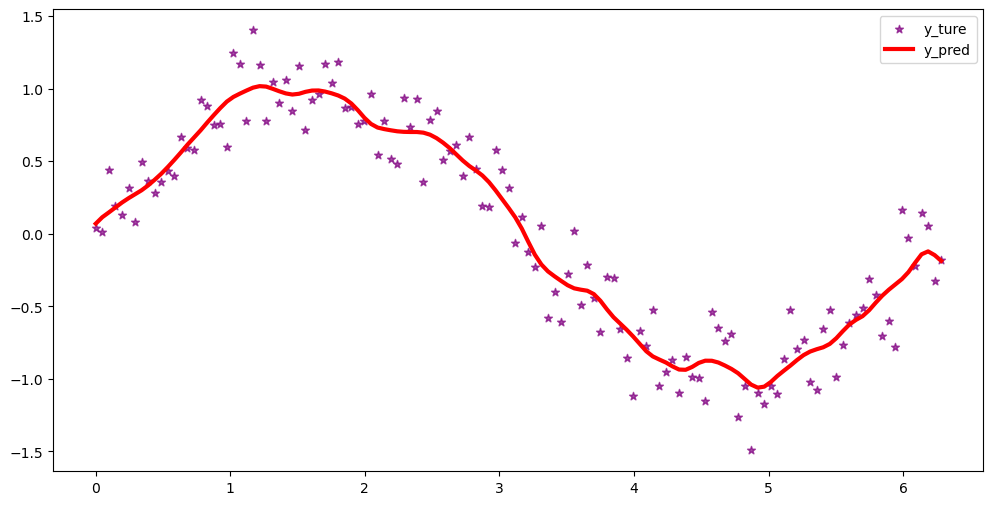

In [10]:
plt.figure(figsize=(12, 6))

plt.scatter(x, y, marker='*', alpha=0.7, s=35, c='purple')
plt.plot(x, y_pred, lw=3, c='red')
plt.legend(['y_ture', 'y_pred'])

# Part 2: _Implementation of simple gradient descent_

In [12]:
# Implementing primary components of gradient descent algorithm

def predict(theta_0, theta_1, x):
    """Predicts using linear regression parameters."""
    return (theta_1 * x) + theta_0

def MSE(y_pred, y_true):
    """Calculates the Means Squared Error."""
    m = len(y_true)
    return (1 / (2 * m)) * ((y_pred - y_true) ** 2).mean()

def one_update_step():
    """Performs One update step of gradient descent."""
    # No need to define xn, y, and m as global variables as they remain unchanged
    global theta_0, theta_1, costs

    y_pred = predict(theta_0, theta_1, xn)
    costs.append(MSE(y_pred, y))

    error = y_pred - y
    dtheta_0 = (1 / m) * np.sum(error)
    dtheta_1 = (1 / m) * np.sum(error * xn)

    theta_0 -= alpha * dtheta_0
    theta_1 -= alpha * dtheta_1

    return theta_0, theta_1

# Part 3: House Price Prediction (Regression Problem)
- ### with LOWESS
- ### with simple Gradient Descent

#### 1. with LOWESS

In [47]:
# Loading dataset

data = np.genfromtxt(fname='house_prices_data.txt', delimiter=',')
x, y = data[:, 0], data[:, 1]

In [49]:
print('Area of the houses(x):', x, f"x.shape: {x.shape}", sep='\n')
print('\nPrice of the houses(y):', y, f"x.shape: {y.shape}", sep='\n')

Area of the houses(x):
[ 2104.  1600.  2400.  1416.  1985.  1534.  1427.  1380.  1494.  1940.
  2000.  1890.  1268.  2300.  1320.  1236.  2609.  1767.  1888.  1604.
  1962.  1100.  1458.  2526.  2200.  2637.  1839.  1000.  2040.  1811.
  1437.  1239.  2132.  2162.  1664.  2238.  2567.  1200.   852.  1852.
  1203.]
x.shape: (41,)

Price of the houses(y):
[ 3999.  3299.  3690.  2320.  2999.  3149.  1989.  2120.  2425.  2399.
  3470.  3299.  2599.  4499.  2999.  1999.  4999.  2529.  2550.  2429.
  2599.  2499.  4645.  4690.  4750.  2999.  3499.  1699.  3149.  2859.
  2499.  2299.  3450.  2870.  3685.  3299.  3140.  2990.  1799.  2999.
  2395.]
x.shape: (41,)


In [55]:
# Sort x, y
idx_sorted = np.argsort(x)
x, y = x[idx_sorted], y[idx_sorted]

x, y

(array([  852.,  1000.,  1100.,  1200.,  1203.,  1236.,  1239.,  1268.,
         1320.,  1380.,  1416.,  1427.,  1437.,  1458.,  1494.,  1534.,
         1600.,  1604.,  1664.,  1767.,  1811.,  1839.,  1852.,  1888.,
         1890.,  1940.,  1962.,  1985.,  2000.,  2040.,  2104.,  2132.,
         2162.,  2200.,  2238.,  2300.,  2400.,  2526.,  2567.,  2609.,
         2637.]),
 array([ 1799.,  1699.,  2499.,  2990.,  2395.,  1999.,  2299.,  2599.,
         2999.,  2120.,  2320.,  1989.,  2499.,  4645.,  2425.,  3149.,
         3299.,  2429.,  3685.,  2529.,  2859.,  3499.,  2999.,  2550.,
         3299.,  2399.,  2599.,  2999.,  3470.,  3149.,  3999.,  3450.,
         2870.,  4750.,  3299.,  4499.,  3690.,  4690.,  3140.,  4999.,
         2999.]))

In [72]:
# Use LOWESS to predict
y_pred = LOWESS(x, y, smoothing_fraction=0.1, num_iterations=5)

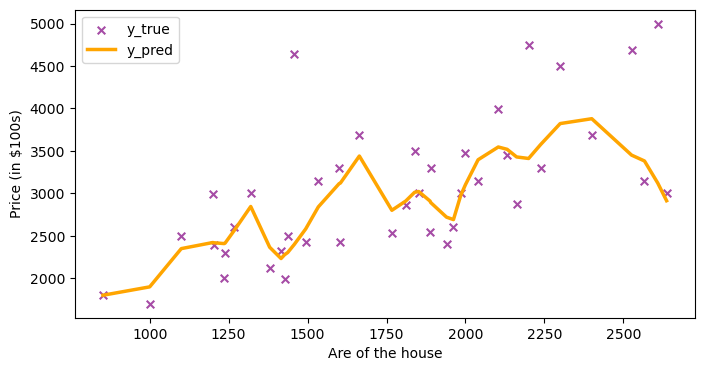

In [84]:
# Create a plot
plt.figure(figsize=(8, 4))

# Scatter plot for real datapoints
plt.scatter(x, y, s=30, c='purple',marker='x', alpha=0.7)

# Plotting predicted prices
plt.plot(x, y_pred, c='orange', lw=2.5)

plt.ylabel('Price (in $100s)')
plt.xlabel('Are of the house')
plt.legend(['y_true', 'y_pred'])

plt.show()

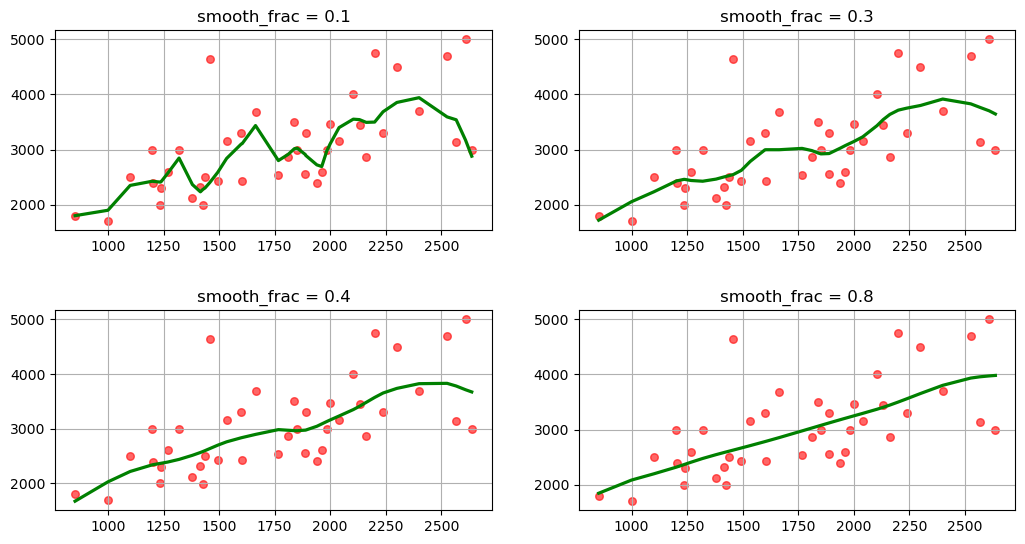

In [114]:
# Predict and plot with different smoothing fraction arguments

plt.figure(figsize=(12, 6))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.4)

smoothing_fraction = [0.1, 0.3, 0.4, 0.8]

for i, f in enumerate(smoothing_fraction):
    plt.subplot(2, 2, i+1)

    y_pred = LOWESS(x, y, f, 4)

    plt.scatter(x, y, s=30, c='red', alpha=0.6)
    plt.plot(x, y_pred, c='green', lw=2.3)
    
    plt.grid(True)
    plt.title(f'smooth_frac = {f}')

plt.show()